In [1]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
import paco.processing.fastpaco as fastPACO

from paco.util.util import *
import cv2 as cv2
from astropy.convolution import convolve, Gaussian2DKernel, AiryDisk2DKernel
from astropy.modeling.models import Gaussian2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 


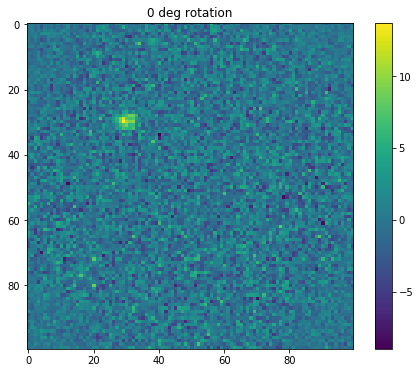

In [2]:
nFrames = 5
angles = np.linspace(0,125,nFrames)#np.array([0, 30, 45, 60, 90])
p0 = (30,30)
sigma = 1 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(nFrames)]
X,Y = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2)

#images_signal = [i + s for i in images]
rot_noise = np.array([rotateImage(images[j], angles[j]) for j in range(nFrames)])
rot_sigs = np.array([rotateImage(s, angles[j]) for j in range(nFrames)])
rot_images = np.array([rot_noise[j] + rot_sigs[j] for j in range(nFrames)])

SNR = (s*nFrames)/(np.sqrt(nFrames) * sigma)
sum_ims = np.sum([rotateImage(rot_images[j], -1.0*angles[j]) for j in range(nFrames)], axis = 0)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
im = ax.imshow(sum_ims)
ax.set_title("0 deg rotation")
fig.colorbar(im,ax = ax)




In [3]:
'''
nFrames = 125
angles = np.linspace(0,180,nFrames)
p0 = (30,30)
sigma = 1.0 # gaussian noise

mean = 0
oa = AiryDisk2DKernel(1)
ps = AiryDisk2DKernel(15)
images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
xf,yf = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
#RHO, THETA = grid_cart_to_pol(xf,yf)

off_axis = convolve(gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2),oa)

images_signal = [i + off_axis for i in images]
rot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.imshow(rot_images[0])
ax.set_title("0 deg rotation")
'''

'\nnFrames = 125\nangles = np.linspace(0,180,nFrames)\np0 = (30,30)\nsigma = 1.0 # gaussian noise\n\nmean = 0\noa = AiryDisk2DKernel(1)\nps = AiryDisk2DKernel(15)\nimages = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]\nxx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))\nxf,yf = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))\n#RHO, THETA = grid_cart_to_pol(xf,yf)\n\noff_axis = convolve(gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2),oa)\n\nimages_signal = [i + off_axis for i in images]\nrot_images = np.array([rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))])\n\nfig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))\nax.imshow(rot_images[0])\nax.set_title("0 deg rotation")\n'

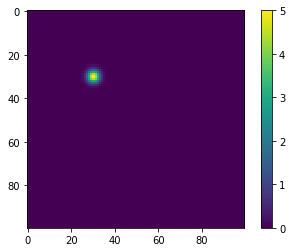

In [4]:
plt.figure()
plt.imshow(SNR)
plt.colorbar()

In [5]:
xx, yy = np.meshgrid(np.arange(-4, 5),np.arange(-4, 5))
s = gaussian2d(xx,yy,1, 2)
s = s/np.sum(s)

fp = fastPACO.FastPACO(patch_size = 49)
fp.set_image_sequence(rot_images)
phi0s = np.array([[70,70]])
a,b = fp.PACO(angles,scale = 1, model_name=psftemplate_model, params={"psf_template":s})
#a,b = fp.PACO_calc(phi0s,angles)
#a,b= fp.PACO(phi0s,angles)

Precomputing Statistics...
PSF template shape (9, 9)
Serial elapsed 0.012673139572143555
here for px [5 5]
here for px [6 5]
here for px [7 5]
here for px [8 5]
here for px [ 5 25]
here for px [ 6 25]
here for px [9 5]
here for px [ 7 25]
here for px [ 8 25]
here for px [10  5]
here for px [ 9 25]
here for px [11  5]
here for px [10 25]
here for px [12  5]
here for px [11 25]
here for px [13  5]
here for px [12 25]
here for px [13 25]
here for px [14  5]
here for px [14 25]
here for px [15  5]
here for px [15 25]
here for px [16  5]
here for px [16 25]
here for px [17  5]
here for px [18  5]
here for px [19  5]
here for px [20  5]
here for px [17 25]
here for px [21  5]
here for px [18 25]
here for px [22  5]
here for px [23  5]
here for px [24  5]
here for px [19 25]
here for px [25  5]
here for px [26  5]
here for px [27  5]
here for px [28  5]
here for px [29  5]
here for px [20 25]
here for px [21 25]
here for px [30  5]
here for px [22 25]
here for px [23 25]
here for px [31  5]
h

here for px [16  7]
here for px [37 27]
here for px [17  7]
here for px [38 27]
here for px [39 27]
here for px [18  7]
here for px [40 27]
here for px [19  7]
here for px [20  7]
here for px [41 27]
here for px [42 27]
here for px [21  7]
here for px [43 27]
here for px [22  7]
here for px [44 27]
here for px [45 27]
here for px [46 27]
here for px [47 27]
here for px [23  7]
here for px [48 27]
here for px [49 27]
here for px [50 27]
here for px [51 27]
here for px [24  7]
here for px [52 27]
here for px [53 27]
here for px [25  7]
here for px [26  7]
here for px [27  7]
here for px [54 27]
here for px [55 27]
here for px [28  7]
here for px [29  7]
here for px [56 27]
here for px [57 27]
here for px [30  7]
here for px [58 27]
here for px [59 27]
here for px [60 27]
here for px [31  7]
here for px [32  7]
here for px [33  7]
here for px [34  7]
here for px [35  7]
here for px [36  7]
here for px [37  7]
here for px [38  7]
here for px [61 27]
here for px [39  7]
here for px [40  7]


here for px [60 29]
here for px [40  9]
here for px [61 29]
here for px [41  9]
here for px [62 29]
here for px [42  9]
here for px [43  9]
here for px [63 29]
here for px [44  9]
here for px [64 29]
here for px [45  9]
here for px [46  9]
here for px [65 29]
here for px [66 29]
here for px [47  9]
here for px [67 29]
here for px [68 29]
here for px [69 29]
here for px [70 29]
here for px [48  9]
here for px [49  9]
here for px [50  9]
here for px [71 29]
here for px [72 29]
here for px [51  9]
here for px [73 29]
here for px [52  9]
here for px [74 29]
here for px [75 29]
here for px [53  9]
here for px [76 29]
here for px [77 29]
here for px [54  9]
here for px [78 29]
here for px [55  9]
here for px [56  9]
here for px [57  9]
here for px [79 29]
here for px [58  9]
here for px [80 29]
here for px [59  9]
here for px [60  9]
here for px [81 29]
here for px [61  9]
here for px [82 29]
here for px [83 29]
here for px [62  9]
here for px [63  9]
here for px [64  9]
here for px [84 29]


here for px [69 11]
here for px [77 31]
here for px [78 31]
here for px [79 31]
here for px [70 11]
here for px [71 11]
here for px [80 31]
here for px [72 11]
here for px [73 11]
here for px [81 31]
here for px [74 11]
here for px [82 31]
here for px [75 11]
here for px [76 11]
here for px [83 31]
here for px [77 11]
here for px [78 11]
here for px [79 11]
here for px [84 31]
here for px [85 31]
here for px [80 11]
here for px [86 31]
here for px [81 11]
here for px [87 31]
here for px [82 11]
here for px [83 11]
here for px [88 31]
here for px [89 31]
here for px [84 11]
here for px [85 11]
here for px [86 11]
here for px [90 31]
here for px [91 31]
here for px [87 11]
here for px [88 11]
here for px [89 11]
here for px [92 31]
here for px [90 11]
here for px [93 31]
here for px [94 31]
here for px [91 11]
here for px [95 31]
here for px [92 11]
here for px [ 5 32]
here for px [ 6 32]
here for px [ 7 32]
here for px [93 11]
here for px [ 8 32]
here for px [ 9 32]
here for px [10 32]


here for px [ 5 34]
here for px [ 5 14]
here for px [ 6 34]
here for px [ 7 34]
here for px [ 6 14]
here for px [ 8 34]
here for px [ 9 34]
here for px [ 7 14]
here for px [10 34]
here for px [ 8 14]
here for px [11 34]
here for px [ 9 14]
here for px [12 34]
here for px [10 14]
here for px [11 14]
here for px [12 14]
here for px [13 34]
here for px [14 34]
here for px [15 34]
here for px [13 14]
here for px [16 34]
here for px [14 14]
here for px [17 34]
here for px [15 14]
here for px [18 34]
here for px [19 34]
here for px [16 14]
here for px [20 34]
here for px [21 34]
here for px [17 14]
here for px [22 34]
here for px [18 14]
here for px [19 14]
here for px [23 34]
here for px [20 14]
here for px [21 14]
here for px [24 34]
here for px [22 14]
here for px [25 34]
here for px [26 34]
here for px [23 14]
here for px [24 14]
here for px [27 34]
here for px [25 14]
here for px [26 14]
here for px [28 34]
here for px [27 14]
here for px [29 34]
here for px [28 14]
here for px [29 14]


here for px [23 16]
here for px [33 36]
here for px [24 16]
here for px [34 36]
here for px [25 16]
here for px [35 36]
here for px [36 36]
here for px [26 16]
here for px [37 36]
here for px [27 16]
here for px [38 36]
here for px [28 16]
here for px [29 16]
here for px [30 16]
here for px [39 36]
here for px [31 16]
here for px [32 16]
here for px [40 36]
here for px [33 16]
here for px [41 36]
here for px [34 16]
here for px [35 16]
here for px [42 36]
here for px [36 16]
here for px [43 36]
here for px [37 16]
here for px [44 36]
here for px [38 16]
here for px [39 16]
here for px [45 36]
here for px [40 16]
here for px [46 36]
here for px [41 16]
here for px [47 36]
here for px [42 16]
here for px [48 36]
here for px [43 16]
here for px [49 36]
here for px [50 36]
here for px [44 16]
here for px [51 36]
here for px [45 16]
here for px [52 36]
here for px [46 16]
here for px [53 36]
here for px [54 36]
here for px [47 16]
here for px [48 16]
here for px [49 16]
here for px [55 36]


here for px [55 18]
here for px [47 38]
here for px [56 18]
here for px [48 38]
here for px [57 18]
here for px [49 38]
here for px [58 18]
here for px [50 38]
here for px [51 38]
here for px [59 18]
here for px [60 18]
here for px [52 38]
here for px [61 18]
here for px [53 38]
here for px [54 38]
here for px [55 38]
here for px [62 18]
here for px [56 38]
here for px [57 38]
here for px [63 18]
here for px [58 38]
here for px [59 38]
here for px [60 38]
here for px [61 38]
here for px [64 18]
here for px [62 38]
here for px [65 18]
here for px [63 38]
here for px [64 38]
here for px [65 38]
here for px [66 18]
here for px [66 38]
here for px [67 18]
here for px [68 18]
here for px [69 18]
here for px [70 18]
here for px [67 38]
here for px [68 38]
here for px [69 38]
here for px [71 18]
here for px [70 38]
here for px [72 18]
here for px [73 18]
here for px [71 38]
here for px [72 38]
here for px [74 18]
here for px [73 38]
here for px [75 18]
here for px [76 18]
here for px [77 18]


here for px [68 20]
here for px [69 20]
here for px [80 40]
here for px [70 20]
here for px [71 20]
here for px [72 20]
here for px [73 20]
here for px [74 20]
here for px [81 40]
here for px [75 20]
here for px [76 20]
here for px [77 20]
here for px [78 20]
here for px [79 20]
here for px [80 20]
here for px [82 40]
here for px [81 20]
here for px [83 40]
here for px [82 20]
here for px [84 40]
here for px [85 40]
here for px [86 40]
here for px [83 20]
here for px [87 40]
here for px [88 40]
here for px [84 20]
here for px [85 20]
here for px [89 40]
here for px [90 40]
here for px [86 20]
here for px [91 40]
here for px [87 20]
here for px [92 40]
here for px [88 20]
here for px [89 20]
here for px [93 40]
here for px [90 20]
here for px [94 40]
here for px [91 20]
here for px [95 40]
here for px [92 20]
here for px [93 20]
here for px [ 5 41]
here for px [94 20]
here for px [ 6 41]
here for px [ 7 41]
here for px [ 8 41]
here for px [95 20]
here for px [ 5 21]
here for px [ 9 41]


here for px [93 22]
here for px [10 43]
here for px [94 22]
here for px [11 43]
here for px [95 22]
here for px [12 43]
here for px [ 5 23]
here for px [13 43]
here for px [14 43]
here for px [ 6 23]
here for px [15 43]
here for px [ 7 23]
here for px [16 43]
here for px [ 8 23]
here for px [ 9 23]
here for px [17 43]
here for px [18 43]
here for px [10 23]
here for px [19 43]
here for px [20 43]
here for px [21 43]
here for px [22 43]
here for px [11 23]
here for px [23 43]
here for px [24 43]
here for px [12 23]
here for px [25 43]
here for px [13 23]
here for px [26 43]
here for px [27 43]
here for px [14 23]
here for px [28 43]
here for px [29 43]
here for px [15 23]
here for px [30 43]
here for px [16 23]
here for px [31 43]
here for px [32 43]
here for px [33 43]
here for px [17 23]
here for px [34 43]
here for px [18 23]
here for px [35 43]
here for px [19 23]
here for px [36 43]
here for px [37 43]
here for px [20 23]
here for px [21 23]
here for px [38 43]
here for px [22 23]


here for px [ 9 50]
here for px [10 50]
here for px [11 50]
here for px [49 45]
here for px [50 45]
here for px [51 45]
here for px [52 45]
here for px [12 50]
here for px [53 45]
here for px [13 50]
here for px [54 45]
here for px [55 45]
here for px [14 50]
here for px [56 45]
here for px [57 45]
here for px [15 50]
here for px [58 45]
here for px [16 50]
here for px [59 45]
here for px [17 50]
here for px [60 45]
here for px [18 50]
here for px [61 45]
here for px [19 50]
here for px [62 45]
here for px [63 45]
here for px [20 50]
here for px [64 45]
here for px [65 45]
here for px [66 45]
here for px [21 50]
here for px [67 45]
here for px [22 50]
here for px [68 45]
here for px [23 50]
here for px [69 45]
here for px [24 50]
here for px [70 45]
here for px [71 45]
here for px [72 45]
here for px [73 45]
here for px [25 50]
here for px [74 45]
here for px [26 50]
here for px [75 45]
here for px [27 50]
here for px [76 45]
here for px [28 50]
here for px [29 50]
here for px [30 50]


here for px [66 47]
here for px [38 52]
here for px [67 47]
here for px [68 47]
here for px [69 47]
here for px [39 52]
here for px [70 47]
here for px [40 52]
here for px [71 47]
here for px [41 52]
here for px [72 47]
here for px [42 52]
here for px [73 47]
here for px [74 47]
here for px [43 52]
here for px [75 47]
here for px [44 52]
here for px [76 47]
here for px [45 52]
here for px [77 47]
here for px [78 47]
here for px [46 52]
here for px [79 47]
here for px [80 47]
here for px [81 47]
here for px [47 52]
here for px [48 52]
here for px [82 47]
here for px [83 47]
here for px [84 47]
here for px [49 52]
here for px [85 47]
here for px [50 52]
here for px [86 47]
here for px [51 52]
here for px [52 52]
here for px [87 47]
here for px [88 47]
here for px [89 47]
here for px [90 47]
here for px [53 52]
here for px [91 47]
here for px [92 47]
here for px [54 52]
here for px [93 47]
here for px [94 47]
here for px [55 52]
here for px [95 47]
here for px [ 5 48]
here for px [ 6 48]


here for px [84 49]
here for px [66 54]
here for px [85 49]
here for px [86 49]
here for px [87 49]
here for px [67 54]
here for px [88 49]
here for px [68 54]
here for px [89 49]
here for px [90 49]
here for px [69 54]
here for px [70 54]
here for px [91 49]
here for px [71 54]
here for px [92 49]
here for px [72 54]
here for px [93 49]
here for px [94 49]
here for px [73 54]
here for px [95 49]
here for px [74 54]
here for px [75 54]
here for px [76 54]
here for px [77 54]
here for px [78 54]
here for px [79 54]
here for px [80 54]
here for px [81 54]
here for px [82 54]
here for px [83 54]
here for px [84 54]
here for px [85 54]
here for px [86 54]
here for px [87 54]
here for px [88 54]
here for px [89 54]
here for px [90 54]
here for px [91 54]
here for px [ 5 75]
here for px [92 54]
here for px [ 6 75]
here for px [ 7 75]
here for px [93 54]
here for px [ 8 75]
here for px [94 54]
here for px [ 9 75]
here for px [10 75]
here for px [11 75]
here for px [95 54]
here for px [ 5 55]


here for px [86 76]
here for px [19 57]
here for px [87 76]
here for px [88 76]
here for px [20 57]
here for px [21 57]
here for px [89 76]
here for px [22 57]
here for px [90 76]
here for px [23 57]
here for px [24 57]
here for px [91 76]
here for px [25 57]
here for px [26 57]
here for px [92 76]
here for px [93 76]
here for px [94 76]
here for px [95 76]
here for px [27 57]
here for px [28 57]
here for px [ 5 77]
here for px [29 57]
here for px [ 6 77]
here for px [ 7 77]
here for px [ 8 77]
here for px [ 9 77]
here for px [30 57]
here for px [31 57]
here for px [32 57]
here for px [10 77]
here for px [33 57]
here for px [11 77]
here for px [34 57]
here for px [35 57]
here for px [12 77]
here for px [36 57]
here for px [37 57]
here for px [13 77]
here for px [14 77]
here for px [38 57]
here for px [15 77]
here for px [39 57]
here for px [40 57]
here for px [41 57]
here for px [42 57]
here for px [16 77]
here for px [17 77]
here for px [43 57]
here for px [18 77]
here for px [44 57]


here for px [17 79]
here for px [43 59]
here for px [44 59]
here for px [45 59]
here for px [46 59]
here for px [18 79]
here for px [47 59]
here for px [19 79]
here for px [48 59]
here for px [49 59]
here for px [20 79]
here for px [50 59]
here for px [21 79]
here for px [51 59]
here for px [52 59]
here for px [22 79]
here for px [23 79]
here for px [53 59]
here for px [24 79]
here for px [25 79]
here for px [54 59]
here for px [26 79]
here for px [55 59]
here for px [27 79]
here for px [28 79]
here for px [29 79]
here for px [56 59]
here for px [30 79]
here for px [31 79]
here for px [57 59]
here for px [32 79]
here for px [58 59]
here for px [59 59]
here for px [60 59]
here for px [33 79]
here for px [61 59]
here for px [34 79]
here for px [35 79]
here for px [36 79]
here for px [62 59]
here for px [37 79]
here for px [63 59]
here for px [38 79]
here for px [39 79]
here for px [64 59]
here for px [40 79]
here for px [65 59]
here for px [66 59]
here for px [67 59]
here for px [41 79]


here for px [38 81]
here for px [68 61]
here for px [69 61]
here for px [39 81]
here for px [70 61]
here for px [71 61]
here for px [72 61]
here for px [73 61]
here for px [40 81]
here for px [74 61]
here for px [75 61]
here for px [41 81]
here for px [76 61]
here for px [77 61]
here for px [42 81]
here for px [78 61]
here for px [79 61]
here for px [80 61]
here for px [43 81]
here for px [81 61]
here for px [82 61]
here for px [44 81]
here for px [83 61]
here for px [45 81]
here for px [84 61]
here for px [46 81]
here for px [85 61]
here for px [47 81]
here for px [86 61]
here for px [48 81]
here for px [87 61]
here for px [88 61]
here for px [49 81]
here for px [50 81]
here for px [89 61]
here for px [90 61]
here for px [51 81]
here for px [52 81]
here for px [91 61]
here for px [92 61]
here for px [53 81]
here for px [93 61]
here for px [94 61]
here for px [95 61]
here for px [54 81]
here for px [ 5 62]
here for px [ 6 62]
here for px [ 7 62]
here for px [ 8 62]
here for px [55 81]


here for px [64 83]
here for px [65 83]
here for px [88 63]
here for px [66 83]
here for px [89 63]
here for px [67 83]
here for px [90 63]
here for px [68 83]
here for px [91 63]
here for px [92 63]
here for px [69 83]
here for px [93 63]
here for px [94 63]
here for px [70 83]
here for px [95 63]
here for px [71 83]
here for px [ 5 64]
here for px [72 83]
here for px [ 6 64]
here for px [73 83]
here for px [ 7 64]
here for px [74 83]
here for px [ 8 64]
here for px [ 9 64]
here for px [10 64]
here for px [75 83]
here for px [11 64]
here for px [12 64]
here for px [76 83]
here for px [13 64]
here for px [14 64]
here for px [77 83]
here for px [15 64]
here for px [16 64]
here for px [78 83]
here for px [17 64]
here for px [79 83]
here for px [18 64]
here for px [19 64]
here for px [80 83]
here for px [20 64]
here for px [21 64]
here for px [22 64]
here for px [81 83]
here for px [23 64]
here for px [24 64]
here for px [25 64]
here for px [82 83]
here for px [83 83]
here for px [26 64]


here for px [29 66]
here for px [78 85]
here for px [30 66]
here for px [31 66]
here for px [79 85]
here for px [32 66]
here for px [80 85]
here for px [33 66]
here for px [81 85]
here for px [82 85]
here for px [34 66]
here for px [83 85]
here for px [35 66]
here for px [36 66]
here for px [84 85]
here for px [37 66]
here for px [85 85]
here for px [86 85]
here for px [38 66]
here for px [87 85]
here for px [88 85]
here for px [89 85]
here for px [39 66]
here for px [90 85]
here for px [91 85]
here for px [40 66]
here for px [41 66]
here for px [92 85]
here for px [93 85]
here for px [42 66]
here for px [94 85]
here for px [43 66]
here for px [44 66]
here for px [45 66]
here for px [95 85]
here for px [ 5 86]
here for px [46 66]
here for px [ 6 86]
here for px [47 66]
here for px [48 66]
here for px [49 66]
here for px [ 7 86]
here for px [50 66]
here for px [51 66]
here for px [ 8 86]
here for px [52 66]
here for px [53 66]
here for px [54 66]
here for px [ 9 86]
here for px [55 66]


here for px [53 68]
here for px [54 68]
here for px [55 68]
here for px [56 68]
here for px [ 9 88]
here for px [57 68]
here for px [58 68]
here for px [10 88]
here for px [11 88]
here for px [59 68]
here for px [12 88]
here for px [13 88]
here for px [60 68]
here for px [61 68]
here for px [62 68]
here for px [63 68]
here for px [14 88]
here for px [64 68]
here for px [65 68]
here for px [15 88]
here for px [66 68]
here for px [16 88]
here for px [67 68]
here for px [68 68]
here for px [69 68]
here for px [17 88]
here for px [70 68]
here for px [71 68]
here for px [72 68]
here for px [18 88]
here for px [73 68]
here for px [74 68]
here for px [19 88]
here for px [75 68]
here for px [76 68]
here for px [77 68]
here for px [20 88]
here for px [78 68]
here for px [79 68]
here for px [80 68]
here for px [21 88]
here for px [81 68]
here for px [82 68]
here for px [22 88]
here for px [83 68]
here for px [84 68]
here for px [85 68]
here for px [86 68]
here for px [23 88]
here for px [24 88]


here for px [ 9 90]
here for px [10 90]
here for px [ 8 71]
here for px [11 90]
here for px [12 90]
here for px [13 90]
here for px [ 9 71]
here for px [14 90]
here for px [15 90]
here for px [16 90]
here for px [17 90]
here for px [10 71]
here for px [18 90]
here for px [19 90]
here for px [11 71]
here for px [20 90]
here for px [12 71]
here for px [13 71]
here for px [14 71]
here for px [15 71]
here for px [21 90]
here for px [16 71]
here for px [17 71]
here for px [22 90]
here for px [18 71]
here for px [19 71]
here for px [23 90]
here for px [20 71]
here for px [21 71]
here for px [22 71]
here for px [24 90]
here for px [23 71]
here for px [24 71]
here for px [25 90]
here for px [25 71]
here for px [26 90]
here for px [26 71]
here for px [27 71]
here for px [28 71]
here for px [29 71]
here for px [27 90]
here for px [30 71]
here for px [31 71]
here for px [32 71]
here for px [33 71]
here for px [34 71]
here for px [28 90]
here for px [35 71]
here for px [29 90]
here for px [36 71]


here for px [19 92]
here for px [44 73]
here for px [20 92]
here for px [21 92]
here for px [45 73]
here for px [22 92]
here for px [46 73]
here for px [47 73]
here for px [23 92]
here for px [48 73]
here for px [49 73]
here for px [24 92]
here for px [50 73]
here for px [25 92]
here for px [51 73]
here for px [26 92]
here for px [27 92]
here for px [52 73]
here for px [28 92]
here for px [29 92]
here for px [53 73]
here for px [30 92]
here for px [31 92]
here for px [54 73]
here for px [32 92]
here for px [55 73]
here for px [33 92]
here for px [56 73]
here for px [34 92]
here for px [35 92]
here for px [57 73]
here for px [58 73]
here for px [36 92]
here for px [59 73]
here for px [37 92]
here for px [38 92]
here for px [39 92]
here for px [60 73]
here for px [40 92]
here for px [61 73]
here for px [41 92]
here for px [42 92]
here for px [62 73]
here for px [63 73]
here for px [64 73]
here for px [65 73]
here for px [66 73]
here for px [43 92]
here for px [67 73]
here for px [44 92]


here for px [13 95]
here for px [14 95]
here for px [15 95]
here for px [16 95]
here for px [17 95]
here for px [18 95]
here for px [19 95]
here for px [20 95]
here for px [21 95]
here for px [22 95]
here for px [23 95]
here for px [24 95]
here for px [25 95]
here for px [26 95]
here for px [27 95]
here for px [28 95]
here for px [29 95]
here for px [30 95]
here for px [31 95]
here for px [32 95]
here for px [33 95]
here for px [34 95]
here for px [35 95]
here for px [36 95]
here for px [37 95]
here for px [38 95]
here for px [39 95]
here for px [40 95]
here for px [41 95]
here for px [42 95]
here for px [43 95]
here for px [44 95]
here for px [45 95]
here for px [46 95]
here for px [47 95]
here for px [48 95]
here for px [49 95]
here for px [50 95]
here for px [51 95]
here for px [52 95]
here for px [53 95]
here for px [54 95]
here for px [55 95]
here for px [56 95]
here for px [57 95]
here for px [58 95]
here for px [59 95]
here for px [60 95]
here for px [61 95]
here for px [62 95]


IndexError: too many indices for array

In [ ]:
img = b/np.sqrt(a)
plt.imshow(img)
plt.colorbar()
